# SkyMapper Import

- Author: Melissa
- Last Run Date: April 2 (HAPPY BIRTHDAY PAUL)
- Issue: https://github.com/astronomy-commons/data.lsdb.io/issues/63



In [1]:
import pandas as pd

import hats_import.pipeline as runner
from hats_import.catalog.arguments import ImportArguments
from hats_import.catalog.file_readers import CsvReader
import pyarrow as pa
import pyarrow.parquet as pq
import os
import hats_import
from dask.distributed import Client

In [2]:
hats_import.__version__

'0.5.0'

We pull the types from the published table metadata: https://skymapper.anu.edu.au/table-browser/

This is necessary as some columns are sparse and runs into [known limitations in the import pipeline](https://hats-import.readthedocs.io/en/latest/notebooks/unequal_schema.html).

In [3]:
## List all of our columns as pyarrow fields.
schema_from_pyarrow = pa.schema(
    [
pa.field('object_id', pa.int64()),
pa.field('raj2000', pa.float64()),
pa.field('dej2000', pa.float64()),
pa.field('e_raj2000', pa.int64(), nullable=True),
pa.field('e_dej2000', pa.int64(), nullable=True),
pa.field('smss_j', pa.string(), nullable=True),
pa.field('mean_epoch', pa.float64(), nullable=True),
pa.field('rms_epoch', pa.float64(), nullable=True),
pa.field('glon', pa.float64(), nullable=True),
pa.field('glat', pa.float64(), nullable=True),
pa.field('flags', pa.int32(), nullable=True),
pa.field('nimaflags', pa.int64(), nullable=True),
pa.field('ngood', pa.int32(), nullable=True),
pa.field('u_flags', pa.int32(), nullable=True),
pa.field('u_nimaflags', pa.int64(), nullable=True),
pa.field('u_ngood', pa.int32(), nullable=True),
pa.field('u_nclip', pa.int32(), nullable=True),
pa.field('v_flags', pa.int32(), nullable=True),
pa.field('v_nimaflags', pa.int64(), nullable=True),
pa.field('v_ngood', pa.int32(), nullable=True),
pa.field('v_nclip', pa.int32(), nullable=True),
pa.field('g_flags', pa.int32(), nullable=True),
pa.field('g_nimaflags', pa.int64(), nullable=True),
pa.field('g_ngood', pa.int32(), nullable=True),
pa.field('g_nclip', pa.int32(), nullable=True),
pa.field('r_flags', pa.int32(), nullable=True),
pa.field('r_nimaflags', pa.int64(), nullable=True),
pa.field('r_ngood', pa.int32(), nullable=True),
pa.field('r_nclip', pa.int32(), nullable=True),
pa.field('i_flags', pa.int32(), nullable=True),
pa.field('i_nimaflags', pa.int64(), nullable=True),
pa.field('i_ngood', pa.int32(), nullable=True),
pa.field('i_nclip', pa.int32(), nullable=True),
pa.field('z_flags', pa.int32(), nullable=True),
pa.field('z_nimaflags', pa.int64(), nullable=True),
pa.field('z_ngood', pa.int32(), nullable=True),
pa.field('z_nclip', pa.int32(), nullable=True),
pa.field('class_star', pa.float64(), nullable=True),
pa.field('chi2_psf', pa.float64(), nullable=True),
pa.field('flags_psf', pa.int64(), nullable=True),
pa.field('radius_petro', pa.float64(), nullable=True),
pa.field('mean_fwhm', pa.float64(), nullable=True),
pa.field('u_psf', pa.float64(), nullable=True),
pa.field('e_u_psf', pa.float64(), nullable=True),
pa.field('u_petro', pa.float64(), nullable=True),
pa.field('e_u_petro', pa.float64(), nullable=True),
pa.field('u_apc05', pa.float64(), nullable=True),
pa.field('e_u_apc05', pa.float64(), nullable=True),
pa.field('u_mmvar', pa.float64(), nullable=True),
pa.field('v_psf', pa.float64(), nullable=True),
pa.field('e_v_psf', pa.float64(), nullable=True),
pa.field('v_petro', pa.float64(), nullable=True),
pa.field('e_v_petro', pa.float64(), nullable=True),
pa.field('v_apc05', pa.float64(), nullable=True),
pa.field('e_v_apc05', pa.float64(), nullable=True),
pa.field('v_mmvar', pa.float64(), nullable=True),
pa.field('g_psf', pa.float64(), nullable=True),
pa.field('e_g_psf', pa.float64(), nullable=True),
pa.field('g_petro', pa.float64(), nullable=True),
pa.field('e_g_petro', pa.float64(), nullable=True),
pa.field('g_apc05', pa.float64(), nullable=True),
pa.field('e_g_apc05', pa.float64(), nullable=True),
pa.field('g_mmvar', pa.float64(), nullable=True),
pa.field('r_psf', pa.float64(), nullable=True),
pa.field('e_r_psf', pa.float64(), nullable=True),
pa.field('r_petro', pa.float64(), nullable=True),
pa.field('e_r_petro', pa.float64(), nullable=True),
pa.field('r_apc05', pa.float64(), nullable=True),
pa.field('e_r_apc05', pa.float64(), nullable=True),
pa.field('r_mmvar', pa.float64(), nullable=True),
pa.field('i_psf', pa.float64(), nullable=True),
pa.field('e_i_psf', pa.float64(), nullable=True),
pa.field('i_petro', pa.float64(), nullable=True),
pa.field('e_i_petro', pa.float64(), nullable=True),
pa.field('i_apc05', pa.float64(), nullable=True),
pa.field('e_i_apc05', pa.float64(), nullable=True),
pa.field('i_mmvar', pa.float64(), nullable=True),
pa.field('z_psf', pa.float64(), nullable=True),
pa.field('e_z_psf', pa.float64(), nullable=True),
pa.field('z_petro', pa.float64(), nullable=True),
pa.field('e_z_petro', pa.float64(), nullable=True),
pa.field('z_apc05', pa.float64(), nullable=True),
pa.field('e_z_apc05', pa.float64(), nullable=True),
pa.field('z_mmvar', pa.float64(), nullable=True),
pa.field('self_id1', pa.int64(), nullable=True),
pa.field('self_dist1', pa.float64(), nullable=True),
pa.field('self_id2', pa.int64(), nullable=True),
pa.field('self_dist2', pa.float64(), nullable=True),
pa.field('self_id3', pa.int64(), nullable=True),
pa.field('self_dist3', pa.float64(), nullable=True),
pa.field('cnt_self_15', pa.float64(), nullable=True),
pa.field('ebmv_sfd', pa.float64(), nullable=True),
pa.field('ebmv_gnilc', pa.float64(), nullable=True),
pa.field('ebmv_g_err', pa.float64(), nullable=True),
pa.field('gaia_dr3_id1', pa.int64(), nullable=True),
pa.field('gaia_dr3_dist1', pa.float64(), nullable=True),
pa.field('gaia_dr3_id2', pa.int64(), nullable=True),
pa.field('gaia_dr3_dist2', pa.float64(), nullable=True),
pa.field('cnt_gaia_dr3_15', pa.int64(), nullable=True),
pa.field('twomass_key', pa.int64(), nullable=True),
pa.field('twomass_dist', pa.float64(), nullable=True),
pa.field('allwise_cntr', pa.int64(), nullable=True),
pa.field('allwise_dist', pa.float64(), nullable=True),
pa.field('catwise_id', pa.string(), nullable=True),
pa.field('catwise_dist', pa.float64(), nullable=True),
pa.field('refcat2_id', pa.int64(), nullable=True),
pa.field('refcat2_dist', pa.float64(), nullable=True),
pa.field('ps1_dr1_id', pa.int64(), nullable=True),
pa.field('ps1_dr1_dist', pa.float64(), nullable=True),
pa.field('galex_guv_id', pa.int64(), nullable=True),
pa.field('galex_guv_dist', pa.float64(), nullable=True),
pa.field('vhs_dr6_id', pa.int64(), nullable=True),
pa.field('vhs_dr6_dist', pa.float64(), nullable=True),
pa.field('ls_dr9_id', pa.int64(), nullable=True),
pa.field('ls_dr9_dist', pa.float64(), nullable=True),
pa.field('des_dr2_id', pa.int64(), nullable=True),
pa.field('des_dr2_dist', pa.float64(), nullable=True),
pa.field('nsc_dr2_id', pa.string(), nullable=True),
pa.field('nsc_dr2_dist', pa.float64(), nullable=True),
pa.field('splus_dr3_id', pa.string(), nullable=True),
pa.field('splus_dr3_dist', pa.float64(), nullable=True),
    ]
)
schema_file = os.path.join("/data3/epyc/data3/hats/raw/skymapper/", "schema_from_pyarrow.parquet")
pq.write_metadata(schema_from_pyarrow, schema_file)

In [4]:
!mkdir /data3/epyc/data3/hats/skymapper/

mkdir: cannot create directory '/data3/epyc/data3/hats/skymapper/': File exists


In [5]:
with Client(
        local_directory="/data3/epyc/data3/hats/tmp/",
        n_workers=30,
        threads_per_worker=1,
    ) as client:
    args = ImportArguments(
        output_artifact_name="sky_mapper_dr4",
        input_path="/data3/epyc/data3/hats/raw/skymapper/dr4_master",
        file_reader=CsvReader(
            chunksize=250_000,
            compression="gzip",
            schema_file=schema_file,
            parquet_kwargs={'dtype_backend' : "pyarrow"},
        ),
        ra_column="raj2000",
        dec_column="dej2000",
        pixel_threshold=1_000_000,
        highest_healpix_order=7,
        drop_empty_siblings=True,
        output_path="/data3/epyc/data3/hats/skymapper/",
        simple_progress_bar=True,
        use_schema_file=schema_file,
        completion_email_address="delucchi@andrew.cmu.edu",
    )
    runner.pipeline_with_client(args, client)

/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34894 instead
  warnings.warn(
Reducing  :  32%|███▏      | 517/1618 [01:47<03:33,  5.16it/s]2025-04-02 06:16:48,229 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:43483' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'reduce_pixel_shards-dd98b281267a9b6af41add45724d67e0', 'reduce_pixel_shards-f2a8893c2150d4e625a7d2f435878c8f', 'reduce_pixel_shards-1f64379f6658beef5f7bc5d03429db08', 'reduce_pixel_shards-c4458354edd498ff1c5777409e2d82d5', 'reduce_pixel_shards-9e07f0b0507acd502e39a7e37958a70c', 'reduce_pixel_shards-6951cd3e8f74c1e48863fc28e935eb0e', 'reduce_pixel_shards-fbf1f437b8d07f1c007de6f0f3701de1', 'reduce_pixel_shards-8fc015263984155a40159ea917b65a2e', 'reduce_pixel_shards-1651f0a65b82e4d3c33ddc5c5d7883fd', 'r

Failed REDUCING stage for shard: 4 1920
  worker address: tcp://127.0.0.1:44669
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_4/dir_0/pixel_1920


2025-04-02 06:16:51,974 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-0be6e38fbe1af591ea64e927bebe1eee
State:     executing
Task:  <Task 'reduce_pixel_shards-0be6e38fbe1af591ea64e927bebe1eee' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_9430')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^

Failed REDUCING stage for shard: 5 9430
  worker address: tcp://127.0.0.1:34197
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_9430


Reducing  :  34%|███▎      | 543/1618 [01:52<03:39,  4.89it/s]2025-04-02 06:16:52,799 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-f2a8893c2150d4e625a7d2f435878c8f
State:     executing
Task:  <Task 'reduce_pixel_shards-f2a8893c2150d4e625a7d2f435878c8f' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10629')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in r

Failed REDUCING stage for shard: 5 10629
  worker address: tcp://127.0.0.1:42987
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10629
Failed REDUCING stage for shard: 5 7374
  worker address: tcp://127.0.0.1:38571
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_7374


Reducing  :  34%|███▎      | 545/1618 [01:52<03:17,  5.42it/s]2025-04-02 06:16:53,129 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-392c45a635280080657e72db048119d5
State:     executing
Task:  <Task 'reduce_pixel_shards-392c45a635280080657e72db048119d5' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_4/dir_0/pixel_2566')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_t

Failed REDUCING stage for shard: 4 2566
  worker address: tcp://127.0.0.1:44170
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_4/dir_0/pixel_2566
Failed REDUCING stage for shard: 4 2455
  worker address: tcp://127.0.0.1:35995
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_4/dir_0/pixel_2455


Reducing  :  34%|███▍      | 549/1618 [01:52<02:53,  6.17it/s]2025-04-02 06:16:53,516 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-fbf1f437b8d07f1c007de6f0f3701de1
State:     executing
Task:  <Task 'reduce_pixel_shards-fbf1f437b8d07f1c007de6f0f3701de1' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_9428')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_t

Failed REDUCING stage for shard: 5 9428
  worker address: tcp://127.0.0.1:44000
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_9428
Failed REDUCING stage for shard: 5 10601
  worker address: tcp://127.0.0.1:45266
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10601


2025-04-02 06:16:53,675 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-c4458354edd498ff1c5777409e2d82d5
State:     executing
Task:  <Task 'reduce_pixel_shards-c4458354edd498ff1c5777409e2d82d5' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10601')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^

Failed REDUCING stage for shard: 5 10437
  worker address: tcp://127.0.0.1:34962
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10437
Failed REDUCING stage for shard: 5 10573
  worker address: tcp://127.0.0.1:44370
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10573


2025-04-02 06:16:54,324 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-dd98b281267a9b6af41add45724d67e0
State:     executing
Task:  <Task 'reduce_pixel_shards-dd98b281267a9b6af41add45724d67e0' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10573')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^

Failed REDUCING stage for shard: 3 605
  worker address: tcp://127.0.0.1:37795
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_3/dir_0/pixel_605
Failed REDUCING stage for shard: 5 7260
  worker address: tcp://127.0.0.1:41472
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_7260


2025-04-02 06:16:54,832 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-8fc015263984155a40159ea917b65a2e
State:     executing
Task:  <Task 'reduce_pixel_shards-8fc015263984155a40159ea917b65a2e' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_7260')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^

Failed REDUCING stage for shard: 3 575
  worker address: tcp://127.0.0.1:37778
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_3/dir_0/pixel_575
Failed REDUCING stage for shard: 4 2717
  worker address: tcp://127.0.0.1:37778
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_4/dir_0/pixel_2717


2025-04-02 06:16:54,866 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-1651f0a65b82e4d3c33ddc5c5d7883fd
State:     executing
Task:  <Task 'reduce_pixel_shards-1651f0a65b82e4d3c33ddc5c5d7883fd' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_3/dir_0/pixel_575')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_table\n    dataset = ParquetDataset(\n              ^^^^^^^^^^^^

Failed REDUCING stage for shard: 3 404
  worker address: tcp://127.0.0.1:35314
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_3/dir_0/pixel_404


Reducing  :  35%|███▍      | 566/1618 [01:55<01:27, 12.07it/s]2025-04-02 06:16:56,250 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-1bb1d1e187e4ec6c3c289fba557d0fa8
State:     executing
Task:  <Task 'reduce_pixel_shards-1bb1d1e187e4ec6c3c289fba557d0fa8' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_9476')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in read_t

Failed REDUCING stage for shard: 5 9476
  worker address: tcp://127.0.0.1:44744
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_0/pixel_9476


Reducing  :  35%|███▌      | 574/1618 [01:57<02:48,  6.18it/s]2025-04-02 06:16:57,680 - distributed.worker - ERROR - Compute Failed
Key:       reduce_pixel_shards-9e07f0b0507acd502e39a7e37958a70c
State:     executing
Task:  <Task 'reduce_pixel_shards-9e07f0b0507acd502e39a7e37958a70c' reduce_pixel_shards(, ...)>
Exception: "FileNotFoundError('/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10447')"
Traceback: '  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 319, in reduce_pixel_shards\n    raise exception\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/hats_import/catalog/map_reduce.py", line 274, in reduce_pixel_shards\n    merged_table = pq.read_table(pixel_dir, schema=schema)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.12/site-packages/pyarrow/parquet/core.py", line 1793, in r

Failed REDUCING stage for shard: 5 10447
  worker address: tcp://127.0.0.1:43399
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10447


Finishing : 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Failed REDUCING stage for shard: 5 10437
  worker address: tcp://127.0.0.1:34962
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10437
Failed REDUCING stage for shard: 4 2566
  worker address: tcp://127.0.0.1:44170
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_4/dir_0/pixel_2566
Failed REDUCING stage for shard: 4 2455
  worker address: tcp://127.0.0.1:35995
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_4/dir_0/pixel_2455
Failed REDUCING stage for shard: 3 404
  worker address: tcp://127.0.0.1:35314
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_3/dir_0/pixel_404
Failed REDUCING stage for shard: 5 10573
  worker address: tcp://127.0.0.1:44370
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_5/dir_10000/pixel_10573
Failed REDUCING stage for shard: 4 1920
  worker address: tcp://127.0.0.1:44669
/data3/epyc/data3/hats/skymapper/sky_mapper_dr4/intermediate/order_4/dir_0/pixel

In [6]:
import hats
from hats.io.validation import is_valid_catalog

is_valid_catalog("/data3/epyc/data3/hats/skymapper/sky_mapper_dr4", strict=True)

Validating catalog at path /data3/epyc/data3/hats/skymapper/sky_mapper_dr4 ... 
Found 1618 partitions.
Approximate coverage is 79.13 % of the sky.


True

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - sky_mapper_dr4'}>)

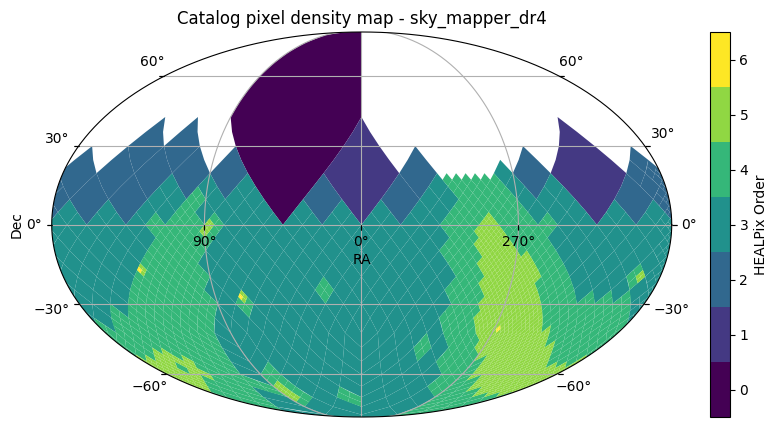

In [7]:
skymapper = hats.read_hats("/data3/epyc/data3/hats/skymapper/sky_mapper_dr4")
skymapper.plot_pixels()